In [2]:
from zipfile import ZipFile

# opens the chess boards.zip file into the chessBoards object
zipFilePath = './archive.zip'
chessBoards = ZipFile(zipFilePath, 'r')

#datasetTest = []
#datasetTrain = []
test = []
train = []
newpath = True

# extract the file names from the train and test folders in the zip archive
for file in chessBoards.namelist():
    # fills the file names from within the dataset subfolder
    """if file[:13] == 'dataset/test/':
        datasetTest.append(file)
    if file[:14] == 'dataset/train/':
        datasetTrain.append(file)"""

    if file[:4] == 'test':
        test.append(file)
    if file[:5] == 'train':
        train.append(file)

    # find any new file paths not accounted for
    """if file[:13] != 'dataset/test/' and \
        file[:14] != 'dataset/train/' and \
        file[:4] != 'test'and \
        file[:5] != 'train' and \
        newpath:
        print("new path: ", file)
        newpath = False"""

print("Files in test: ", len(test))
print("Files in train: ", len(train))



Files in test:  20000
Files in train:  80000


In [10]:
import pickle
from PIL import Image
import io
import os
from zipfile import ZipFile
import random

# Extracts the data from the zip file and saves it to a pickle file
#
# @param[in] zipFilePath - the path to the zip file
# @param[in] outputPickleFile - the path to the pickle file to save the data to
# @param[in] directory - the directory within the zip file to extract the data from
# @param[in] sampleAmount - the number of samples to extract from the zip file
def extractData(zipFilePath, outputPickleFile, directory='test/', sampleAmount=None):
    data = []

    with ZipFile(zipFilePath, 'r') as chess_boards:
        # Get all file names in the zip file that start with the directory
        file_names = [name for name in chess_boards.namelist() if name.startswith(directory)]

        # Shuffle the file names to get a random sample
        random.shuffle(file_names)

        for file_name in file_names:
            if file_name.startswith(directory):
                # Extract FEN string from file name
                fen_string = file_name.split('/')[-1]

                # Extract image bytes and convert to PIL Image
                with chess_boards.open(file_name) as image_file:
                    image_bytes = image_file.read()
                    image = Image.open(io.BytesIO(image_bytes))

                    # Converts image to grayscale
                    image = image.convert('L')

                # Append FEN string and image to data
                data.append((fen_string, image))

                # Check if the desired number of samples is reached
                if sampleAmount is not None and len(data) >= sampleAmount:
                    break

    # Get the directory path and base filename
    output_dir, base_filename = os.path.split(outputPickleFile)
    
    # Include the number of samples in the base filename
    if sampleAmount is not None:
        base_filename = f"{os.path.splitext(base_filename)[0]}_{sampleAmount}.pickle"
    
    # Construct the full output pickle file path
    outputPickleFile = os.path.join(output_dir, base_filename)

    # Save data to pickle file
    with open(outputPickleFile, 'wb') as pickle_file:
        pickle.dump(data, pickle_file)

    print(f"Data extracted and saved to {outputPickleFile}")

# Entry point to start the process of pickling the data
def pickleData():
    zipFilePath = './archive.zip'
    outputPickleFile = './test_data.pickle'
    extractData(zipFilePath, outputPickleFile, "test/", 100)

    outputPickleFile = './train_data.pickle'
    extractData(zipFilePath, outputPickleFile, "train/", 1000)

pickleData()


Data extracted and saved to .\test_data_100.pickle
Data extracted and saved to .\train_data_1000.pickle


Loading training data from pickle file...
Extracting images and labels from training data...


C:\Users\shubh\AppData\Local\Temp\ipykernel_37708\4229926352.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.get_cmap('viridis', 10))


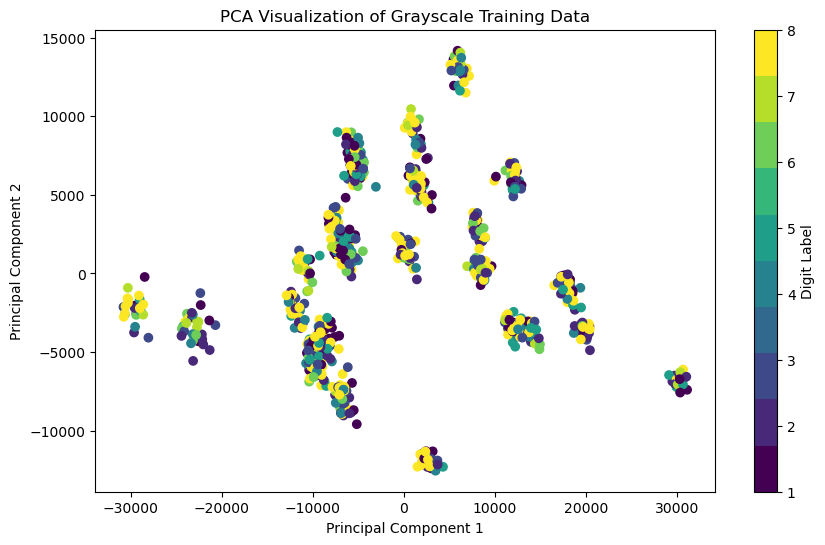

Training model...
Model trained
Loading test data from pickle file...
Extracting images and labels from test data...
Predicting labels...
Evaluating accuracy...
Model accuracy: 0.0
Actual: 2R1r2B-2k4P-8-8-6P1-4B3-1K1rB1r1-2B2Bb1.jpeg, Predicted: 8-p7-6B1-B5k1-2r3R1-6p1-K5nP-rB2r3.jpeg
Actual: 1nR5-8-8-8-1p3n2-1P6-8-b3K2k.jpeg, Predicted: q7-8-3r1N2-4r2p-1RK2k1R-8-8-2b5.jpeg
Actual: 5N2-BB6-4b3-6k1-6R1-8-P2K4-q6r.jpeg, Predicted: 5K1n-1b3R2-5q2-1N6-8-5k2-3n4-7B.jpeg
Actual: 2R5-5Kp1-8-2Q3k1-8-6q1-8-6n1.jpeg, Predicted: 2K5-3r4-2P5-2bQ4-p3n3-8-3P4-7k.jpeg
Actual: 4k3-8-8-N3n3-1K6-8-P7-2r5.jpeg, Predicted: 4QnN1-8-1NK1qPN1-3r2r1-8-R7-2b5-5k2.jpeg


In [33]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import re

# Trains a model using the training data from the pickle file
#
# @param[in] trainingDataFile - the path to the pickle file containing the training data
# @return - the trained Random Forest model
def trainModel(trainingDataFile):
    # Load the training data from the pickle file
    print("Loading training data from pickle file...")
    with open(trainingDataFile, 'rb') as file:
        trainingData = pickle.load(file)

    # Extract the images and labels from the data
    print("Extracting images and labels from training data...")
    X_train = np.array([np.array(data[1]).flatten() for data in trainingData])
    # Extract labels from filenames
    y_train = []
    for data in trainingData:
        match = re.match(r'^(\d)', data[0])
        if match:
            y_train.append(int(match.group(1)))
        else:
            # Handle cases where the pattern doesn't match
            y_train.append(None)

    y_train = np.array(y_train)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)

    # Visualize the data in 2D
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.get_cmap('viridis', 10))
    plt.colorbar(label='Digit Label')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Visualization of Grayscale Training Data')
    plt.show()

    y_train = [data[0] for data in trainingData]
    # Train the Random Forest model
    print("Training model...")
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=None)
    model.fit(X_train, y_train)

    return model

def evaluateModel(model, testDataFile):
    # Load the test data from the pickle file
    print("Loading test data from pickle file...")
    with open(testDataFile, 'rb') as file:
        testData = pickle.load(file)

    # Extract the images and labels from the data
    print("Extracting images and labels from test data...")
    X_test = np.array([np.array(data[1]).flatten() for data in testData])
    y_test = [data[0] for data in testData]

    # Predict the labels using the model
    print("Predicting labels...")
    y_pred = model.predict(X_test)

    # Evaluate the model using accuracy
    print("Evaluating accuracy...")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy}")

    for actual, pred in zip(y_test[:5], y_pred[:5]):
        print(f"Actual: {actual}, Predicted: {pred}")

# Entry point to train the model and evaluate it
def main():

    # Train
    model = trainModel('./train_data_1000.pickle')
    print("Model trained")

    # Evaluate
    evaluateModel(model, './test_data_100.pickle')

main()
